In [114]:
from datetime import datetime
from datetime import timezone
import polars as pl
import os

acropolis_directory = "../data"

In [115]:
df = pl.scan_parquet(os.path.join(acropolis_directory, "pivot_measurements.parquet"))
#df = pl.scan_parquet(os.path.join(acropolis_directory, "old_db_renamed_measurements.parquet"))

df = df.sort("creation_timestamp")
df.head(3).collect()

system_name,revision,creation_timestamp,receipt_timestamp,wxt532_direction_min,wxt532_speed_min,wxt532_last_update_time,wxt532_speed_avg,wxt532_direction_avg,wxt532_direction_max,wxt532_speed_max,gmp343_compensated,bme280_humidity,sht45_temperature,bme280_pressure,sht45_humidity,gmp343_raw,bme280_temperature,gmp343_filtered,gmp343_temperature,enclosure_bme280_humidity,raspi_cpu_usage,enclosure_bme280_pressure,raspi_cpu_temperature,raspi_disk_usage,raspi_memory_usage,enclosure_bme280_temperature,cal_gmp343_compensated,cal_gmp343_raw,cal_bme280_temperature,cal_gmp343_filtered,cal_sht45_temperature,cal_bme280_pressure,cal_sht45_humidity,cal_gmp343_temperature,cal_bme280_humidity,cal_bottle_id
str,i32,"datetime[ns, UTC]","datetime[ns, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""tum-esm-midcos…",23,2023-09-21 13:29:45.460 UTC,2023-09-21 13:29:47.860321 UTC,null,null,null,null,null,null,null,401.4,22.63,31.52,920.84,24.9,346.0,31.35,398.9,33.2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""tum-esm-midcos…",23,2023-09-21 13:29:45.520 UTC,2023-09-21 13:29:47.924263 UTC,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,14.88,0.033,941.95,58.9,0.358,0.109,37.79,null,null,null,null,null,null,null,null,null,null
"""tum-esm-midcos…",23,2023-09-21 13:29:55.470 UTC,2023-09-21 13:29:56.827854 UTC,null,null,null,null,null,null,null,404.5,22.65,31.51,925.06,24.91,346.7,31.35,405.4,33.1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [116]:
df = df.with_columns([pl.when(pl.col("cal_gmp343_filtered") < 600).then(pl.col("cal_gmp343_filtered")).otherwise(None).alias("cal_400"),
                      pl.when(pl.col("cal_gmp343_filtered") > 600).then(pl.col("cal_gmp343_filtered")).otherwise(None).alias("cal_800"),
                      pl.when(pl.col("cal_gmp343_filtered") < 600).then(pl.col("cal_bottle_id")).otherwise(None).alias("cal_bottle_id_400"),
                      pl.when(pl.col("cal_gmp343_filtered") > 600).then(pl.col("cal_bottle_id")).otherwise(None).alias("cal_bottle_id_800")])

In [117]:
dfg = df.groupby([pl.col("creation_timestamp").dt.date(), pl.col("system_name")]).agg([pl.col("cal_400").drop_nulls(),
                                                                                    pl.col("cal_800").drop_nulls(),
                                                                                    pl.col("cal_bottle_id_400").drop_nulls().median(),
                                                                                    pl.col("cal_bottle_id_800").drop_nulls().median()])

In [118]:
def average_bottle(data):
    data = data.to_list()
    #2nd bottle
    if 50 < len(data) < 70:
        x = data[int(len(data)*0.3):int(len(data)*0.95)]
        return sum(x) / len(x)
    #1st bottle
    elif 70 < len(data) < 130:
        x = data[int(len(data)*0.5):int(len(data)*0.95)]
        return sum(x) / len(x)
    else:
        return 0.0

dfg = dfg.select([pl.col("creation_timestamp"),
            pl.col("system_name"),
            pl.col("cal_400").apply(lambda x: average_bottle(x)).alias("mean_cal_400"),
            pl.col("cal_800").apply(lambda x: average_bottle(x)).alias("mean_cal_800"),
            pl.col("cal_bottle_id_400"),
            pl.col("cal_bottle_id_800")
            ])

dfg.collect()

creation_timestamp,system_name,mean_cal_400,mean_cal_800,cal_bottle_id_400,cal_bottle_id_800
date,str,f64,f64,f64,f64
2023-09-21,"""tum-esm-midcos…",0.0,0.0,null,null
2023-09-21,"""tum-esm-midcos…",0.0,0.0,null,null
2023-09-21,"""tum-esm-midcos…",0.0,0.0,null,null
2023-09-23,"""tum-esm-midcos…",0.0,0.0,null,null
2023-09-23,"""tum-esm-midcos…",0.0,0.0,null,null
2023-09-23,"""tum-esm-midcos…",0.0,0.0,null,null
2023-09-24,"""tum-esm-midcos…",0.0,0.0,null,null
2023-09-24,"""tum-esm-midcos…",0.0,0.0,null,null
2023-09-25,"""tum-esm-midcos…",0.0,0.0,null,null


# Calculate slope and intercept

In [119]:
df_gas = pl.read_csv("../data/averaged_gases.csv")

In [120]:
def two_point_calibration(measured_values, true_values):
    # Check if input lists have length 2
    if len(measured_values) != 2 or len(true_values) != 2:
        raise ValueError("Both measured_values and true_values must have length 2")

    # Calculate calibration parameters (slope and intercept)
    # 
    slope = (true_values[1] - true_values[0]) / (measured_values[1] - measured_values[0])
    # y_true = m * y_meas + t
    intercept = true_values[0] - slope * measured_values[0]

    return slope, intercept

def calc_slope(meas_400, meas_800, id_400, id_800):
    if (meas_400 == None) or (meas_800 == None):
        return None
    
    bottles_meas = [meas_400, meas_800]
    bottles_true = [df_gas.filter(pl.col("Bottle_ID")== id_400)["CO2_dry"][0],df_gas.filter(pl.col("Bottle_ID")== id_800)["CO2_dry"][0]]

    slope, intercept = two_point_calibration(bottles_meas, bottles_true)
    
    return slope

def calc_intercept(meas_400, meas_800, id_400, id_800):
    if (meas_400 == None) or (meas_800 == None):
        return None
    
    bottles_meas = [meas_400, meas_800]
    bottles_true = [df_gas.filter(pl.col("Bottle_ID")== id_400)["CO2_dry"][0],df_gas.filter(pl.col("Bottle_ID")== id_800)["CO2_dry"][0]]

    slope, intercept = two_point_calibration(bottles_meas, bottles_true)
    
    return intercept

dfg = dfg.sort(pl.col("creation_timestamp")) \
    .filter(pl.col("mean_cal_400") > 0.0 ) \
    .filter(pl.col("mean_cal_800") > 0.0 )

dfg = dfg.with_columns(pl.struct(['mean_cal_400','mean_cal_800','cal_bottle_id_400','cal_bottle_id_800']) \
    .apply(lambda x: calc_slope(x['mean_cal_400'],x['mean_cal_800'],x['cal_bottle_id_400'],x['cal_bottle_id_800'])) \
    .alias('slope'))

dfg = dfg.with_columns(pl.struct(['mean_cal_400','mean_cal_800','cal_bottle_id_400','cal_bottle_id_800']) \
    .apply(lambda x: calc_intercept(x['mean_cal_400'],x['mean_cal_800'],x['cal_bottle_id_400'],x['cal_bottle_id_800'])) \
    .alias('intercept'))

dfg.collect()

creation_timestamp,system_name,mean_cal_400,mean_cal_800,cal_bottle_id_400,cal_bottle_id_800,slope,intercept
date,str,f64,f64,f64,f64,f64,f64
2023-10-11,"""tum-esm-midcos…",397.5675,788.618519,22.0,29.0,1.021045,0.741947
2023-10-12,"""tum-esm-midcos…",401.777778,799.535897,11.0,35.0,1.025841,-11.891104
2023-10-12,"""tum-esm-midcos…",387.714286,778.47027,19.0,24.0,1.006225,23.447039
2023-10-12,"""tum-esm-midcos…",419.366667,826.220513,5.0,12.0,0.982361,4.625427
2023-10-12,"""tum-esm-midcos…",386.727273,783.810811,21.0,28.0,1.033429,1.07311
2023-10-12,"""tum-esm-midcos…",388.325926,776.166667,4.0,14.0,1.056566,-10.761366
2023-10-12,"""tum-esm-midcos…",401.15,815.015385,3.0,39.0,1.026678,-20.506601
2023-10-12,"""tum-esm-midcos…",405.261111,819.479487,6.0,34.0,0.975783,6.094465
2023-10-12,"""tum-esm-midcos…",381.666667,788.789744,22.0,29.0,0.980737,32.361613


In [121]:
dfg.collect().write_parquet("../data/calibration_correction.parquet")

In [122]:
dfg_test = dfg.sort(pl.col("creation_timestamp")) \
    .filter(pl.col("system_name") == "tum-esm-midcost-raspi-2") \
    
dfg_test.collect().tail(5)

creation_timestamp,system_name,mean_cal_400,mean_cal_800,cal_bottle_id_400,cal_bottle_id_800,slope,intercept
date,str,f64,f64,f64,f64,f64,f64
2023-10-12,"""tum-esm-midcos…",388.325926,776.166667,4.0,14.0,1.056566,-10.761366
2023-10-13,"""tum-esm-midcos…",390.105,778.864815,4.0,14.0,1.054068,-11.666653
2023-10-14,"""tum-esm-midcos…",389.67963,778.141026,4.0,14.0,1.054878,-11.533824


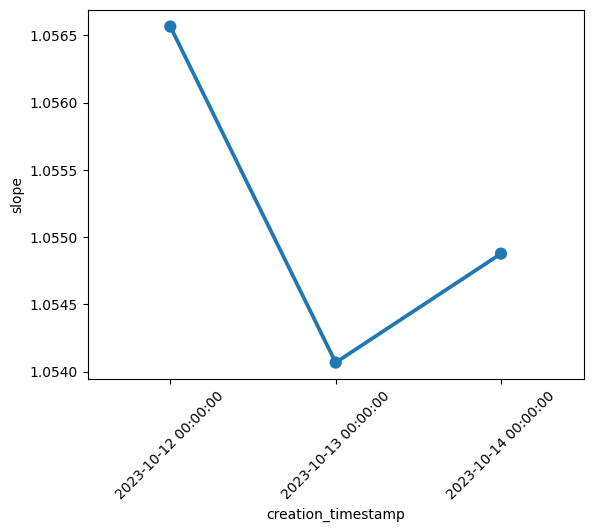

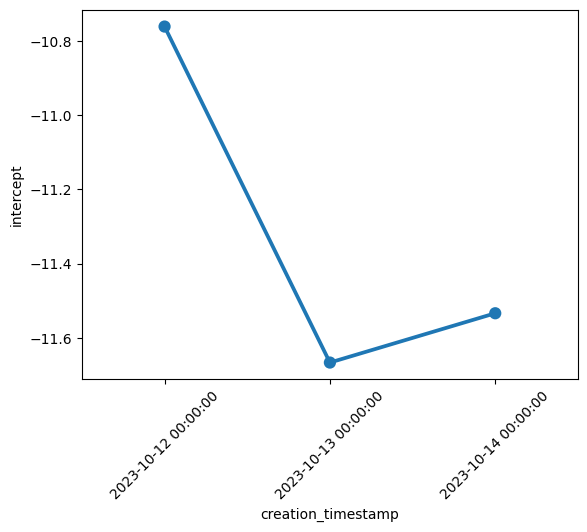

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.pointplot(data=dfg_test.collect().to_pandas(), x="creation_timestamp", y="slope")
plt.xticks(rotation=45)
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))
plt.show()

sns.pointplot(data=dfg_test.collect().to_pandas(), x="creation_timestamp", y="intercept")
plt.xticks(rotation=45)
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))
plt.show()
